# Week-6 Assignment ( S.Venkata Sreeram )

## Transfer learning on CIFAR100 dataset using RESNET 34

## GETTING THE NECESSARY MODULES 

In [42]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.models as models
%matplotlib inline

# EXPLORING THE DATA

In [44]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar100.tgz


In [45]:
# Extract from archive
with tarfile.open('./cifar100.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

The dataset is extracted to the directory data/cifar100. 
It contains 2 folders train and test, containing the training set (50000 images) and test set (10000 images) respectively. 
Each of them contains 10 folders, one for each class of images. We can verify this using os.listdir.

In [46]:
data_dir = './data/cifar100'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['medium_mammals', 'vehicles_1', 'fish', 'household_electrical_devices', 'large_omnivores_and_herbivores', 'fruit_and_vegetables', 'people', 'aquatic_mammals', 'household_furniture', 'trees', 'vehicles_2', 'large_man-made_outdoor_things', 'flowers', 'large_carnivores', 'large_natural_outdoor_scenes', 'food_containers', 'small_mammals', 'reptiles', 'insects', 'non-insect_invertebrates']


In [47]:
x=len(os.listdir('./data/cifar100/train'))
print(f"No. of classes: {x}")
y=len(os.listdir('./data/cifar100/train/aquatic_mammals'))
print(f"No. of sub classes in each class: {y}")
z=len(os.listdir('./data/cifar100/train/aquatic_mammals/beaver'))
print(f"Total objects inside a subclass: {z}")

print(f"TRAINING SET CONTAINS {x*y*z} IMAGES")

No. of classes: 20
No. of sub classes in each class: 5
Total objects inside a subclass: 500
TRAINING SET CONTAINS 50000 IMAGES


In [48]:
x=len(os.listdir('./data/cifar100/test'))
print(f"No. of classes: {x}")
y=len(os.listdir('./data/cifar100/test/aquatic_mammals'))
print(f"No. of sub classes in each class: {y}")
z=len(os.listdir('./data/cifar100/test/aquatic_mammals/beaver'))
print(f"Total objects inside a subclass: {z}")

print(f"TESTING SET CONTAINS {x*y*z} IMAGES")

No. of classes: 20
No. of sub classes in each class: 5
Total objects inside a subclass: 100
TESTING SET CONTAINS 10000 IMAGES


In [49]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

# CHECKING AN IMAGE OF THE DATASET

In [50]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0)) #channel are at the last in matplotlib where it was at front in tensors

Label:  aquatic_mammals (0)


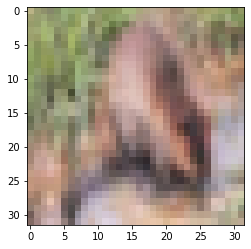

In [51]:
show_example(*dataset[6]) #args use 

# Training and Validation Datasets

1)Let's normalize our data for uniformity(Standard Normal Deviation).

2)Let's apply randomly chosen transformations while loading images from the training dataset.

3)Let's take the validation set from the test dataset instead of allocating certain portion of training dataset.


In [52]:
# Data transforms (normalization & data augmentation)
stats = ((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

We can use the ImageFolder class from torchvision to load the data as PyTorch tensors.

In [53]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)
test_ds = ImageFolder(data_dir+'/test', valid_tfms)

Let's create data loaders for retrieving images in batches as using the whole dataset isnot that effective in terms of memory and time so we shall create batches of data from the exisitng dataset and work on them

In [54]:
batch_size = 250

In [55]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

Let's take a look at some sample images from the training dataloader.

Each elemet of the dataloader is a tuple containing a image tensor and a label .
Since the data consists of 32x32 px color images with 3 channels (RGB), each image tensor has the shape (3, 32, 32).

images.shape: torch.Size([250, 3, 32, 32])


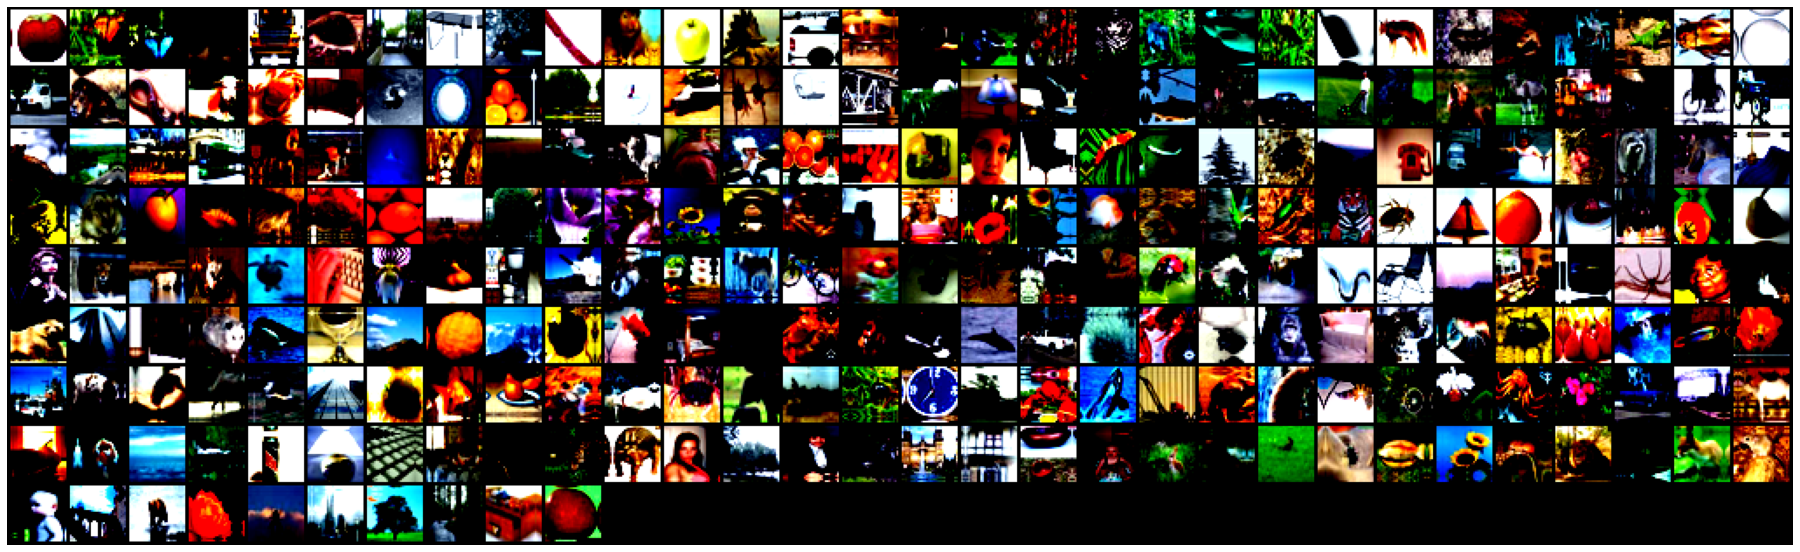

In [56]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(32,32))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=30).permute((1, 2, 0)))
    break

## lets view our batch of images

In [57]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

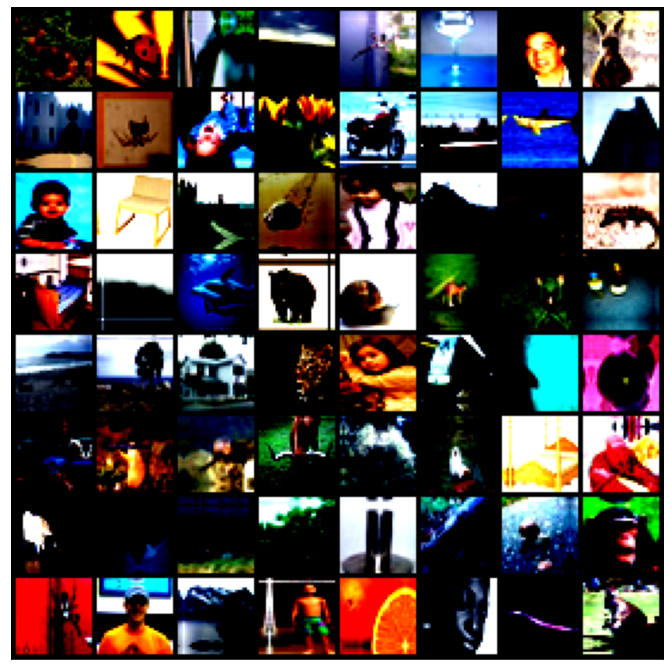

In [58]:
show_batch(train_dl)

# MAKING USE OF GPU (IF PRESENT)

To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [59]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [60]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available), and use to_device to move our model to the GPU (if available).

In [61]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# LET'S WORK TOWARDS OUR MODEL  

## EXTENDING THE MODEL

In [62]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [63]:
resnet34 = models.resnet34()
resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [64]:
class CIFAR100Resnet(ImageClassificationBase):
        def __init__(self):
                super().__init__()
                self.network = torchvision.models.resnet34()
                num_ftrs = self.network.fc.in_features
                self.network.fc = nn.Linear(num_ftrs, 100)
        
        def forward(self, xb):
                return self.network(xb)
            
model = CIFAR100Resnet()
model

CIFAR100Resnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

# TRAINING THE MODEL

In [65]:
model = to_device(CIFAR100Resnet(), device)

In [66]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, 
        weight_decay=0, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [67]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 5.35524320602417, 'val_acc': 0.0}]

In [68]:
# For this model we gonna use Adam Optimization
opt_func = torch.optim.Adam

In [69]:
history = fit(8, 1e-3, model, train_dl, valid_dl, 5e-4, opt_func)

Epoch [0], train_loss: 2.4287, val_loss: 2.2092, val_acc: 0.3208
Epoch [1], train_loss: 2.0382, val_loss: 2.0168, val_acc: 0.3679
Epoch [2], train_loss: 1.8611, val_loss: 1.8274, val_acc: 0.4260
Epoch [3], train_loss: 1.7424, val_loss: 1.7318, val_acc: 0.4535
Epoch [4], train_loss: 1.6497, val_loss: 1.6679, val_acc: 0.4791
Epoch [5], train_loss: 1.5796, val_loss: 1.6221, val_acc: 0.4923
Epoch [6], train_loss: 1.5155, val_loss: 1.5320, val_acc: 0.5165
Epoch [7], train_loss: 1.4659, val_loss: 1.5070, val_acc: 0.5218


In [70]:
history = fit(10, 1e-5, model, train_dl, valid_dl, 5e-4, opt_func)

Epoch [0], train_loss: 1.3152, val_loss: 1.2756, val_acc: 0.5944
Epoch [1], train_loss: 1.2459, val_loss: 1.2392, val_acc: 0.6059
Epoch [2], train_loss: 1.2155, val_loss: 1.2220, val_acc: 0.6106
Epoch [3], train_loss: 1.1895, val_loss: 1.2115, val_acc: 0.6106
Epoch [4], train_loss: 1.1759, val_loss: 1.2052, val_acc: 0.6137
Epoch [5], train_loss: 1.1692, val_loss: 1.1968, val_acc: 0.6162
Epoch [6], train_loss: 1.1543, val_loss: 1.1912, val_acc: 0.6158
Epoch [7], train_loss: 1.1425, val_loss: 1.1865, val_acc: 0.6201
Epoch [8], train_loss: 1.1312, val_loss: 1.1826, val_acc: 0.6202
Epoch [9], train_loss: 1.1248, val_loss: 1.1792, val_acc: 0.6206


In [71]:
history = fit(5, 1e-4, model, train_dl, valid_dl, 5e-4, opt_func)

Epoch [0], train_loss: 1.1592, val_loss: 1.1857, val_acc: 0.6212
Epoch [1], train_loss: 1.1215, val_loss: 1.1629, val_acc: 0.6288
Epoch [2], train_loss: 1.0953, val_loss: 1.1568, val_acc: 0.6316
Epoch [3], train_loss: 1.0637, val_loss: 1.1446, val_acc: 0.6339
Epoch [4], train_loss: 1.0414, val_loss: 1.1491, val_acc: 0.6340


In [72]:
history = fit(15, 1e-4, model, train_dl, valid_dl, 5e-4, opt_func)

Epoch [0], train_loss: 1.0126, val_loss: 1.1478, val_acc: 0.6368
Epoch [1], train_loss: 0.9879, val_loss: 1.1350, val_acc: 0.6415
Epoch [2], train_loss: 0.9680, val_loss: 1.1356, val_acc: 0.6426
Epoch [3], train_loss: 0.9522, val_loss: 1.1313, val_acc: 0.6448
Epoch [4], train_loss: 0.9261, val_loss: 1.1310, val_acc: 0.6450
Epoch [5], train_loss: 0.9077, val_loss: 1.1447, val_acc: 0.6439
Epoch [6], train_loss: 0.8885, val_loss: 1.1373, val_acc: 0.6472
Epoch [7], train_loss: 0.8702, val_loss: 1.1459, val_acc: 0.6437
Epoch [8], train_loss: 0.8482, val_loss: 1.1284, val_acc: 0.6500
Epoch [9], train_loss: 0.8288, val_loss: 1.1268, val_acc: 0.6473
Epoch [10], train_loss: 0.8108, val_loss: 1.1542, val_acc: 0.6462
Epoch [11], train_loss: 0.7912, val_loss: 1.1386, val_acc: 0.6507
Epoch [12], train_loss: 0.7691, val_loss: 1.1339, val_acc: 0.6539
Epoch [13], train_loss: 0.7575, val_loss: 1.1495, val_acc: 0.6528
Epoch [14], train_loss: 0.7365, val_loss: 1.1786, val_acc: 0.6493


In [73]:
history = fit(25, 1e-5, model, train_dl, valid_dl, 5e-4, opt_func)

Epoch [0], train_loss: 0.6518, val_loss: 1.1120, val_acc: 0.6656
Epoch [1], train_loss: 0.6234, val_loss: 1.1172, val_acc: 0.6659
Epoch [2], train_loss: 0.6159, val_loss: 1.1236, val_acc: 0.6662
Epoch [3], train_loss: 0.6008, val_loss: 1.1243, val_acc: 0.6657
Epoch [4], train_loss: 0.5927, val_loss: 1.1294, val_acc: 0.6674
Epoch [5], train_loss: 0.5853, val_loss: 1.1347, val_acc: 0.6661
Epoch [6], train_loss: 0.5797, val_loss: 1.1362, val_acc: 0.6662
Epoch [7], train_loss: 0.5783, val_loss: 1.1375, val_acc: 0.6668
Epoch [8], train_loss: 0.5748, val_loss: 1.1461, val_acc: 0.6667
Epoch [9], train_loss: 0.5626, val_loss: 1.1474, val_acc: 0.6667
Epoch [10], train_loss: 0.5568, val_loss: 1.1501, val_acc: 0.6669
Epoch [11], train_loss: 0.5498, val_loss: 1.1556, val_acc: 0.6635
Epoch [12], train_loss: 0.5477, val_loss: 1.1565, val_acc: 0.6654
Epoch [13], train_loss: 0.5399, val_loss: 1.1660, val_acc: 0.6642
Epoch [14], train_loss: 0.5379, val_loss: 1.1634, val_acc: 0.6659
Epoch [15], train_lo

# MAKING PREDICTIONS 

In [74]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Label: aquatic_mammals , Predicted: aquatic_mammals


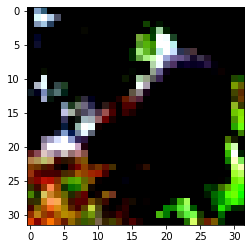

In [75]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: flowers , Predicted: flowers


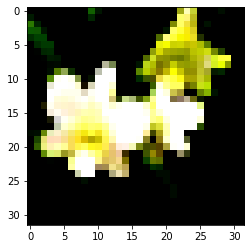

In [76]:
img, label = test_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: household_furniture , Predicted: household_furniture


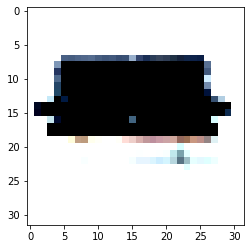

In [77]:
img, label = test_ds[3252]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [78]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.1912610530853271, 'val_acc': 0.6672999262809753}

# GRAPHICAL REPRESENTATION OF SOME TERMS 

In [79]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

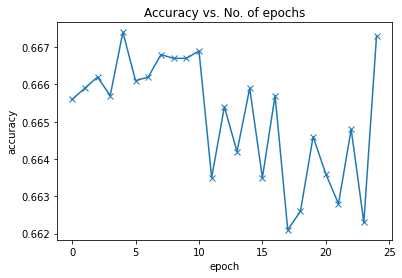

In [80]:
plot_accuracies(history)

In [81]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

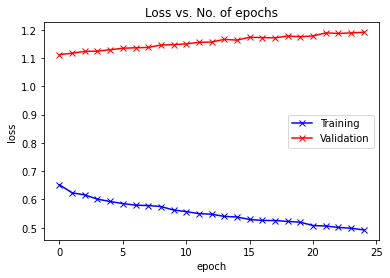

In [82]:
plot_losses(history)

In [87]:
torch.save(model.state_dict(), 'cifar100-resnet-course-project.pth')